# Install dependencies

In [59]:
%pip install scikit-image
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import main packages

In [2]:
from PIL import Image
import numpy as np 
import skimage
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual

# Load a cube

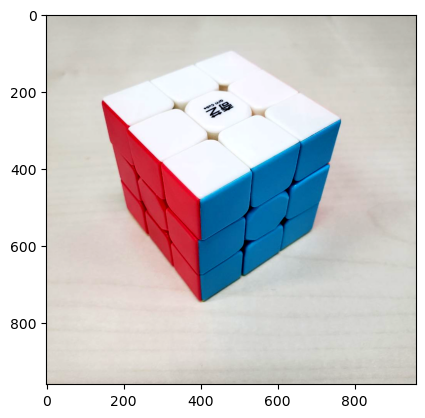

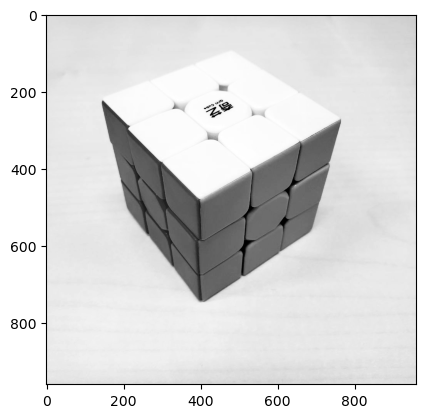

In [4]:

from skimage.color import rgb2gray, rgb2xyz
from skimage.exposure import adjust_sigmoid
from skimage.filters import gaussian
from skimage.exposure import equalize_adapthist, rescale_intensity, adjust_sigmoid

def crop_at_center(image):
    width, height, _ = image.shape
    size = min([height, width]) / 2

    return image[
        round(width/2 - size): round(width/2 + size),
        round(height/2 - size): round(height/2 + size),
    ]

cube = skimage.io.imread("test_images/unmessy_0.jpg")
cube = crop_at_center(cube)

p2, p98 = np.percentile(cube, (2, 98))
cube = rescale_intensity(cube, in_range=(p2, p98))

grey_cube = 1 - rgb2gray(cube)

plt.imshow(cube)
plt.show()

plt.imshow(grey_cube, cmap="Greys")
plt.show()

In [6]:
from skimage.feature import canny
from skimage.morphology import binary_dilation

def show_borders(sigma, dilation):
    borders = canny(grey_cube, sigma)
    
    kernel = np.ones(shape=(dilation, dilation))
    dilated = binary_dilation(borders, kernel)

    plt.imshow(dilated, cmap="Greys")
    plt.show()

interact(show_borders, sigma=(0, 10, 0.1), dilation=(1, 10))

interactive(children=(FloatSlider(value=5.0, description='sigma', max=10.0), IntSlider(value=5, description='d…

<function __main__.show_borders(sigma, dilation)>

In [7]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.segmentation import slic, mark_boundaries, watershed, felzenszwalb
from skimage.filters import sobel

def segment_by_color(n_segments, compactness, sigma):
    segments = slic(cube, n_segments=n_segments, compactness=compactness, sigma=sigma)
    plt.imshow(segments, interpolation="nearest")
    plt.show()

interact(segment_by_color, n_segments=(0, 100), compactness=(0.1, 1), sigma=(0, 3, 0.1))

# def segment_by_color(scale, sigma, min_size):
#     segments = felzenszwalb(cube, scale=scale, sigma=sigma, min_size=min_size)
#     plt.imshow(segments, interpolation="nearest")
#     plt.show()

# interact_manual(segment_by_color, scale=(0, 100), sigma=(0.1, 1), min_size=50)

interactive(children=(IntSlider(value=50, description='n_segments'), FloatSlider(value=0.55, description='comp…

<function __main__.segment_by_color(n_segments, compactness, sigma)>

In [8]:
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line

def extract_lines(sigma, line_length, line_width, line_gap):
    borders = canny(grey_cube, sigma)
    kernel = np.ones(shape=(line_width, line_width))
    dilated = binary_dilation(borders, kernel)

    h_angles = np.arange(0, np.pi, 0.01)

    lines = probabilistic_hough_line(dilated, theta=h_angles, threshold=300, line_length=line_length, line_gap=line_gap)

    plt.imshow(cube, alpha=0.4)
    for p0, p1 in lines:
        x = [p0[0], p1[0]]
        y = [p0[1], p1[1]]
        plt.plot(x, y, linewidth=line_width)
    plt.show()

interact(extract_lines, sigma=(0, 5, 0.1), line_length=(0, 500), line_width=(0, 10), line_gap=(0, 1000))

interactive(children=(FloatSlider(value=2.0, description='sigma', max=5.0), IntSlider(value=250, description='…

<function __main__.extract_lines(sigma, line_length, line_width, line_gap)>

In [9]:
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks


def sort_indexes(array):
    sorted_flat_indexes = np.argsort(array.flatten())
    indexes = []
    for i in sorted_flat_indexes:
        j = np.unravel_index(i, array.shape)
        indexes.append(tuple(j))
    return indexes

def extract_lines(sigma, min_distance, min_angle, line_width):
    borders = canny(grey_cube, sigma)
    kernel = np.ones(shape=(line_width, line_width))
    dilated = binary_dilation(borders, kernel)

    bla = hough_line_peaks(*hough_line(dilated), num_peaks=50, min_distance=min_distance, min_angle=min_angle)

    print(len(bla[1]))
        
    plt.imshow(dilated, cmap="Greys")
    for _, angle, dist in zip(*bla):
        slope = np.tan(angle + np.pi/2)
        x0, y0 = dist * np.array([np.cos(angle), np.sin(angle)])
        plt.axline((x0, y0), slope=slope, color="darkred")

    # print(borders.shape)
    # print(hough_space.shape)
    # print(angles.shape)
    # print(distances.shape)



    # plt.imshow(np.log(1 + hough_space), aspect='auto', cmap="inferno")
    plt.show()

    # plt.imshow(lines)
    # plt.show()
    # for p0, p1 in lines:
    #     x = [p0[0], p1[0]]
    #     y = [p0[1], p1[1]]
    #     plt.plot(x, y, linewidth=line_width)
    # plt.show()

interact(extract_lines, sigma=(0, 5, 0.1), min_distance=(0, 200), min_angle=(0,200), line_width=(1, 10))

interactive(children=(FloatSlider(value=2.0, description='sigma', max=5.0), IntSlider(value=100, description='…

<function __main__.extract_lines(sigma, min_distance, min_angle, line_width)>

# extract cube mask

In [11]:
from skimage.feature import canny
from skimage.morphology import binary_dilation
from scipy.ndimage import binary_fill_holes
from skimage.morphology import binary_opening, convex_hull_image

def extract_cube(sigma, dilation):
    borders = canny(grey_cube, sigma)
    kernel = np.ones(shape=(dilation, dilation))

    filled_cube = convex_hull_image(borders)
    filled_cube = binary_opening(filled_cube, kernel)

    plt.imshow(filled_cube, cmap="Greys")
    plt.imshow(borders, cmap="inferno", alpha=0.5)
    plt.show()

interact(extract_cube, sigma=(0, 10, 0.1), dilation=(1, 10))

interactive(children=(FloatSlider(value=5.0, description='sigma', max=10.0), IntSlider(value=5, description='d…

<function __main__.extract_cube(sigma, dilation)>